# Looking for a pipeline for segmenting seeds in images

## Status

- 2023-07-23: The segmentation is working fairly well except for one thing,
    - I cannot join the seed head to the seed body yet.

In [1]:
import math
from pathlib import Path

import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage
from ipywidgets import fixed, interact
from scipy import fft
from scipy import ndimage as ndi
from scipy import signal
from scipy.cluster.vq import kmeans2
from scipy.signal import convolve2d as conv2
from skimage import color, data, draw
from skimage import exposure as exp
from skimage import feature as feat
from skimage import filters, graph, img_as_float, io, measure
from skimage import morphology as morph
from skimage import restoration as rest
from skimage import segmentation as seg
from skimage import transform as trans
from skimage import util
from skimage.filters import rank, thresholding

In [2]:
IMAGE_DIR = Path(".") / "data" / "images"

matplotlib.rcParams.update({"font.size": 11})

In [3]:
suffixes = (".jpeg", ".png")

PATHS = [p for p in IMAGE_DIR.glob("*.*") if p.suffix in suffixes]
path = PATHS[0]

## Get initial grayscale image

(dtype('uint8'), 18, 254)

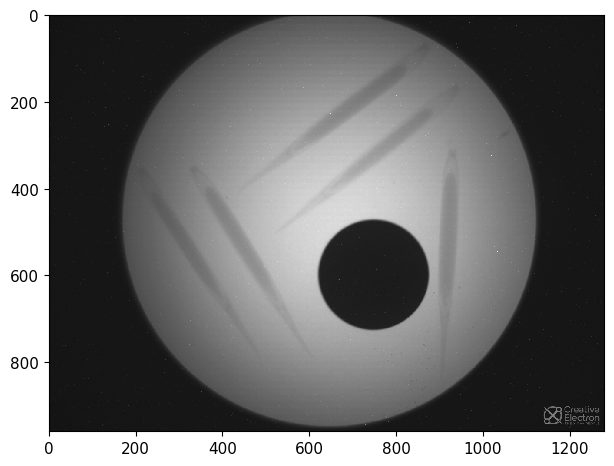

In [4]:
orig = io.imread(path)
gray = np.uint8(color.rgb2gray(orig) * 255.0)
io.imshow(gray)
gray.dtype, gray.min(), gray.max()

## Display a before & after manipulation pair of images

In [5]:
def two_up(input_image, output_image, output_title):
    fig, axes = plt.subplots(
        nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16, 8)
    )
    ax = axes.ravel()

    ax[0].imshow(input_image, cmap=plt.cm.gray)
    ax[0].set_title("input image")
    ax[0].axis("off")

    ax[1].imshow(output_image, cmap=plt.cm.gray)
    ax[1].set_title(output_title)
    ax[1].axis("off")

    plt.show()

## Get an image mask

In [6]:
def get_mask(gray, threshold=48):
    mask = threshold < gray

    # mask = morph.binary_erosion(mask)

    rr, cc = draw.rectangle((750, 1100), mask.shape, shape=mask.shape)
    mask[rr, cc] = 0

    two_up(gray, mask, "mask")
    return mask

In [7]:
def mask_image(image, mask):
    new = image.copy() * mask
    two_up(image, new, "mask_image")
    return new

## Functions for manipulating images

#### Morphology functions

In [8]:
def binary_dilation(image, footprint=None):
    new = morph.binary_dilation(chain, footprint=footprint)
    two_up(image, new, "binary_dilation")
    return new

In [9]:
def remove_small_holes(image, area_threshold=0):
    new = morph.remove_small_holes(image, area_threshold=area_threshold)
    two_up(image, new, "remove_small_holes")
    return new

In [10]:
def remove_small_objects(image, min_size=0):
    new = morph.remove_small_objects(image, min_size=min_size)
    two_up(image, new, "remove_small_objects")
    return new

#### Exposure functions

In [11]:
def adjust_gamma(image, gamma=1.0, gain=1.0):
    new = exp.adjust_gamma(image, gamma=gamma, gain=gain)
    two_up(image, new, "adjust_gamma")
    return new

In [12]:
def adjust_log(image, gain=1.0, inv=False):
    new = exp.adjust_log(image, gain=gain, inv=inv)
    two_up(image, new, "adjust_log")
    return new

In [13]:
def adjust_sigmoid(image, cutoff=0.5, gain=10, inv=False):
    new = exp.adjust_sigmoid(image, cutoff=cutoff, gain=gain, inv=inv)
    two_up(image, new, "adjust_sigmoid")
    return new

In [14]:
def equalize_adapthist(image, nbins=255, kernel_size=None, clip_limit=0.01):
    new = exp.equalize_adapthist(
        image, nbins=nbins, kernel_size=kernel_size, clip_limit=clip_limit
    )
    two_up(image, new, "equalize_adapthist")
    return new

#### Feature functions

In [15]:
def canny(image, sigma=1):
    new = feat.canny(image, sigma=sigma)
    two_up(image, new, "canny")
    return new

#### Filter functions

In [16]:
def farid(image, mask=None):
    new = filters.farid(image, mask=mask)
    two_up(image, new, "farid")
    return new

In [17]:
def meijering(image, black_ridges, sigmas):
    new = filters.meijering(image, black_ridges=black_ridges, sigmas=sigmas)
    two_up(image, new, "meijering")
    return new

In [18]:
def prewitt(image, mask=None):
    new = filters.prewitt(image, mask=mask)
    two_up(image, new, "prewitt")
    return new

In [19]:
def roberts(image, mask=None):
    new = filters.roberts(image, mask=mask)
    two_up(image, new, "roberts")
    return new

In [20]:
def sato(image, black_ridges, sigmas):
    new = filters.sato(image, black_ridges=black_ridges, sigmas=sigmas)
    two_up(image, new, "sato")
    return new

In [21]:
def sobel(image, mask=None):
    new = filters.sobel(image, mask=mask)
    two_up(image, new, "sobel")
    return new

In [22]:
def threshold_otsu(image):
    thresh = filters.threshold_otsu(image)
    binary = image > thresh
    binary = binary & mask
    two_up(image, binary, "threshold_otsu")
    return binary

In [23]:
def threshold_yen(image):
    thresh = filters.threshold_yen(image)
    binary = image > thresh
    binary = binary & mask
    two_up(image, binary, "threshold_yen")
    return binary

In [24]:
def unsharp_mask(image, radius=1, amount=1):
    new = filters.unsharp_mask(image, radius=radius, amount=amount)
    two_up(image, new, "unsharp_mask")
    return new

#### Rank filter functions

In [25]:
def autolevel_percentile(image, disk=50, low=0.2, high=0.8, mask=None):
    new = filters.rank.autolevel_percentile(
        image, footprint=morph.disk(disk), p0=low, p1=high, mask=mask
    )
    two_up(image, new, "autolevel_percentile")
    return new

In [26]:
def enhance_contrast_disk(image, radius=5, mask=None):
    new = rank.enhance_contrast(image, footprint=morph.disk(radius), mask=mask)
    two_up(image, new, "enhance_contrast_disk")
    return new

In [27]:
def equalize_disk(image, radius=5, mask=None):
    new = rank.equalize(image, footprint=morph.disk(radius), mask=mask)
    two_up(image, new, "equalize_disk")
    return new

In [28]:
def maximum_disk(image, radius=5, mask=None):
    new = rank.maximum(image, morph.disk(radius), mask=mask)
    two_up(image, new, "maximum_disk")
    return new

In [29]:
def majority_disk(image, radius=5, mask=None):
    new = rank.majority(image, morph.disk(radius), mask=mask)
    two_up(image, new, "majority_disk")
    return new

In [30]:
def mean_disk(image, radius=5, mask=None):
    new = rank.mean(image, morph.disk(radius), mask=mask)
    two_up(image, new, "mean_disk")
    return new

In [31]:
def mean_bilateral_disk(image, radius=5, mask=None):
    new = rank.mean_bilateral(image, morph.disk(radius), mask=mask)
    two_up(image, new, "mean_bilateral_disk")
    return new

In [32]:
def minimum_disk(image, radius=5, mask=None):
    new = rank.minimum(image, morph.disk(radius), mask=mask)
    two_up(image, new, "minimum_disk")
    return new

In [33]:
def otsu_disk(image, radius=5, mask=None):
    new = rank.otsu(image, morph.disk(radius), mask=mask)
    two_up(image, new, "otsu_disk")
    return new

#### Utility functions

In [34]:
def invert(image):
    new = util.invert(image)
    two_up(image, new, "invert")
    return new

## The pipeline

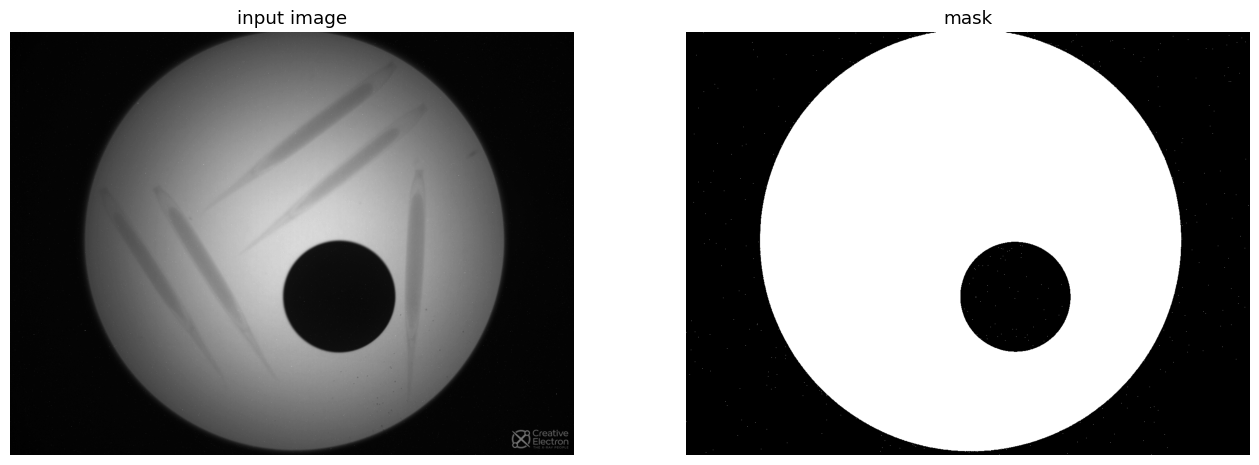

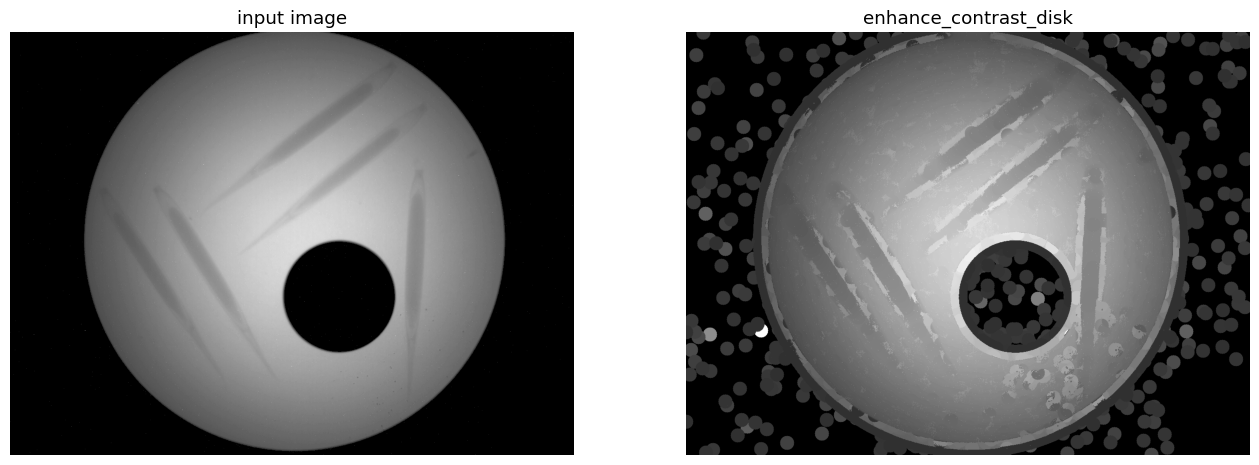

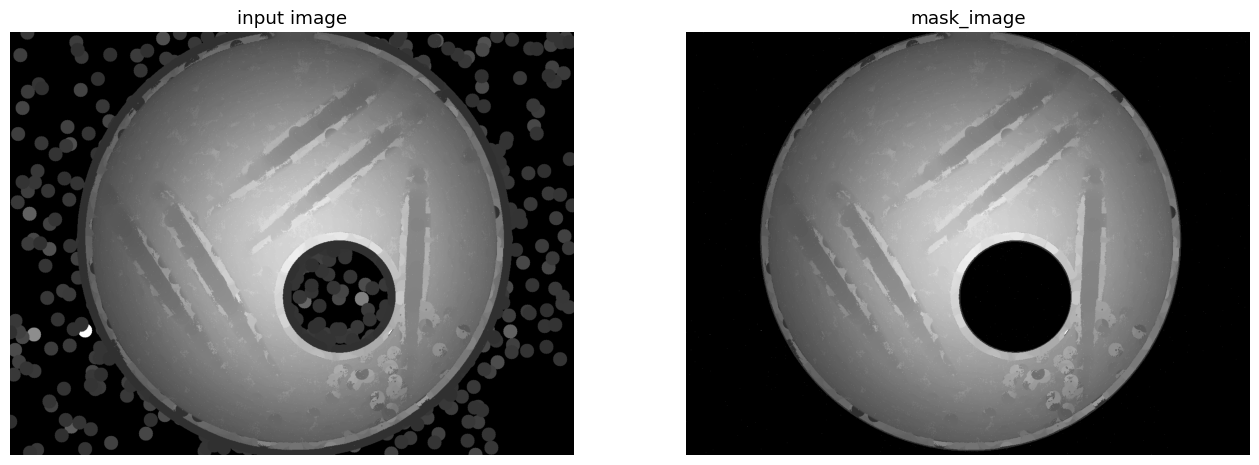

uint8 (960, 1280)
bool (960, 1280)


In [35]:
mask = get_mask(gray)
# imask = invert(mask)

image = gray.copy()
image *= mask

# image = autolevel_percentile(image, mask=mask)
image = enhance_contrast_disk(image, mask=mask, radius=16)
image = mask_image(image, mask)
# image = otsu_disk(image, mask=mask)
# image = invert(image)
# image = equalize_disk(image, radius=32)
# image = threshold_yen(image)
# image = threshold_otsu(image)
# image = remove_small_holes(image, area_threshold=64)

# image = adjust_sigmoid(image)
# image = adjust_gamma(image)

# image = farid(image, mask)

# image = equalize_adapthist(image)

# image = threshold_otsu(image)
# image = remove_small_holes(image, 255)

# image = sobel(image, mask)
# image = sato(image, black_ridges=False, sigmas=(1, 2, 3, 4))

print(image.dtype, image.shape)
print(mask.dtype, mask.shape)

## Use interactive graphics to explore image manipulations

I set it up so that you can use a partial pipeline, from above, and then run one of these interactive functions to see which arguments yield the best results.

In [49]:
# interact(
#     enhance_contrast_disk,
#     image=fixed(image),
#     mask=fixed(mask),
#     radius=(0, 1000),
# )

In [37]:
# interact(
#     mean_bilateral_disk,
#     image=fixed(image),
#     mask=fixed(mask),
#     radius=(0, 1000),
# )

In [38]:
# interact(
#     majority_disk,
#     image=fixed(image),
#     mask=fixed(mask),
#     radius=(1, 200),
# )

In [39]:
# interact(
#     canny,
#     image=fixed(image),
#     sigma=(0.0, 10.0),
# )

In [40]:
# interact(
#     equalize_disk,
#     image=fixed(image),
#     mask=fixed(mask),
#     radius=(1, 200),
# )

In [41]:
# interact(
#     adjust_sigmoid,
#     image=fixed(image),
#     cutoff=(0.0, 1.0),
#     gain=(0.0, 100.0),
#     inv=False,
# )

In [42]:
# interact(
#     equalize_adapthist,
#     image=fixed(image),
#     kernel_size=(1, 2000),
#     clip_limit=(0.0, 1.0),
#     nbins=(1, 512),
# )

In [43]:
# interact(
#     adjust_gamma,
#     image=fixed(image),
#     gamma=(0.0, 10.0),
#     gain=(0.0, 10.0),
# )

In [44]:
# interact(
#     adjust_log,
#     image=fixed(image),
#     gain=(0.0, 100.0),
#     inv=False,
# )

In [45]:
# interact(
#     auto_level,
#     image=fixed(image),
#     footprint_disk=(0, 100),
#     low=(0.0, 1.0, 0.01),
#     high=(0.0, 1.0, 0.01),
# )

In [46]:
# interact(
#     unsharp_mask,
#     image=fixed(image),
#     radius=(0, 200),
#     amount=(-20.0, 20.0),
# )

## Parked functions that may prove useful in the future

In [47]:
# def hough(binary, threshold=10, line_length=5, line_gap=4):
#     theta = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
#     lines = trans.probabilistic_hough_line(
#         binary,
#         threshold=threshold,
#         line_length=line_length,
#         line_gap=line_gap,
#         theta=theta,
#     )

#     # Generating figure 2
#     fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
#     ax = axes.ravel()

#     ax[0].imshow(binary, cmap=plt.cm.gray)
#     ax[0].set_title("Binary Image")
#     ax[0].set_axis_off()

#     ax[1].imshow(binary, cmap=plt.cm.gray)
#     for line in lines:
#         p0, p1 = line
#         ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
#     ax[1].set_xlim((0, binary.shape[1]))
#     ax[1].set_ylim((binary.shape[0], 0))
#     ax[1].set_title("Probabilistic Hough")
#     ax[1].set_axis_off()

#     plt.tight_layout()
#     plt.show()

In [48]:
# def remove_circles(image, edges, small=75, large=500, count=4):
#     # Detect two radii
#     hough_radii = np.arange(small, large, 4)
#     hough_res = trans.hough_circle(edges, hough_radii)

#     # Select the most prominent 2 circles
#     accums, cx, cy, radii = trans.hough_circle_peaks(
#         hough_res, hough_radii, total_num_peaks=count
#     )

#     fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))

#     image = color.gray2rgb(image)
#     for center_y, center_x, radius in zip(cy, cx, radii):
#         circy, circx = draw.circle_perimeter(
#             center_y, center_x, radius, shape=image.shape
#         )
#         image[circy, circx] = (220, 20, 20)

#     ax.imshow(image, cmap=plt.cm.gray)
#     plt.show()

#     return image

# no_circles = remove_circles(autolevel, binary, count=2)